#Functions and code for plotting MEATseq m6A probability stats and read clustering

#jup notebook for analyzing 1x601 Chromatin DiMeLo-seq, CENP-A assembly in extract
#DiMeLo V2 trial3 - 1x 601, HsCA Chr Gly Frac 1, HSE +/- HJURP or no HSE, naked, DiMeLo (XlCA, HsCA) v Fiberseq, pA-Hia5

In [1]:
#Input Megaladon output - mod_mappings.bam (filter by length to keep file size small)
#Template - 1x601.fa
#Functions:
# parse_bam6_fast - takes in bam file, reads through each read entry and outputs prob score at each A and coverage at each position along the given template. Other outputs include smoothed/sliding window averaged prob score, binary output for m6A call at each A position, number of modified A's and number of A's per read for other statistics, readids.
# extract_Ml_Aa_fast - takes in Mm and Ml from Megaladon output for each read. converts to array with just m6A calls with the correct index (removes mC prob scores)
# m6A_seqmap_prob_fast - takes in positions of A's and T's along template and assigns prob scores from Ml of megaladon output

In [1]:
%%bash
#mkdir '/home/groups/astraigh/ont_minion/jups/DiMeLo_v2_invitro'
mkdir '/home/groups/astraigh/ont_minion/jups/DiMeLo_v2_invitro/20221122_v2_trial3_1x601'

In [2]:
##Replace <outdir> with output directory
outfolder = '/home/groups/astraigh/ont_minion/jups/DiMeLo_v2_invitro/20221122_v2_trial3_1x601'

In [25]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import kde
%matplotlib inline

import math

import pysam
from Bio import SeqIO

from scipy import sparse

from sklearn import cluster, datasets, mixture, decomposition

import scipy.spatial.distance as ssd
from scipy.cluster import hierarchy
from sklearn.metrics.pairwise import pairwise_distances

In [26]:
#enter name of folder that contains bar1.1, bar1.2,.. etc. bam files mod_basecalled from megalodon
folder_name = '/scratch/groups/astraigh/minion_seq/megalodon/DiMeLo_v2_invitro_trial3/'

In [27]:
Barcode_name = {}

In [28]:
#List Barcode titles to be used for graphs here: (For example)
Barcode_name['21'] = 'HsCA Chr, HSE+HJURP, Fiber'
Barcode_name['22'] = 'HsCA Chr, HSE-HJURP, Fiber'
Barcode_name['03'] = 'HsCA Chr, Buffer, Fiber'
Barcode_name['04'] = 'HsCA Chr, HSE+HJURP, D-XlCA'
Barcode_name['23'] = 'HsCA Chr, HSE-HJURP, D-XlCA'
Barcode_name['24'] = 'HsCA Chr, Buffer, D-XlCA'
Barcode_name['07'] = 'HsCA Chr, HSE+HJURP, D-HsCA'
Barcode_name['08'] = 'HsCA Chr, HSE-HJURP, D-HsCA'
Barcode_name['09'] = 'HsCA Chr, Buffer, D-HsCA'
Barcode_name['10'] = 'H3 Chr, HSE+HJURP, Fiber'
Barcode_name['11'] = 'H3 Chr, Buffer, Fiber'
Barcode_name['12'] = 'H3 Chr, HSE+HJURP, D-XlCA'
Barcode_name['13'] = 'H3 Chr, Buffer, D-XlCA'
Barcode_name['14'] = 'H3 Chr, HSE+HJURP, D-HsCA'
Barcode_name['15'] = 'H3 Chr, Buffer, D-HsCA'
Barcode_name['16'] = 'Naked, HSE+HJURP, Fiber'
Barcode_name['17'] = 'Naked, Buffer, Fiber'
Barcode_name['18'] = 'Naked, Untreated'
Barcode_name['19'] = 'HsCA Chr, Buffer, D-Enzo-HsCA'
Barcode_name['20'] = 'H3 Chr, Buffer, D-Enzo-HsCA'


In [29]:
Barcode_list = [i for i in Barcode_name.keys()]

In [9]:
Barcode_list

['21',
 '22',
 '03',
 '04',
 '23',
 '24',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20']

In [30]:
#reading in template into string - filepath/template.fa
array_seq = SeqIO.read("/home/groups/astraigh/ont_minion/plasmids/pGEM_3z_601.fa", "fasta")
array_str = str(array_seq.seq)

In [31]:
#array_str = array_str2[1770:2525]

In [32]:
len(array_str)

3022

In [33]:
#identifying indices of A's and T's for assigning mod probs to right positions

A_pos = []
T_pos = []
for basepos in range(0,len(array_str)-1):
    if array_str[basepos]=='A':
        A_pos.append(basepos)
    elif array_str[basepos]=='T':
        T_pos.append(basepos)

In [34]:
# extracting m6A prob from Ml, counting A
# input Mm Ml from bam and thr
# output - Mm first value, truncated m6A prob, total A count

In [35]:
def extract_Ml_Aa_fast(Mm, Ml):
         
    first=Mm.split(';')[0]
    if 'C+m' in first:
        A_n=len(Mm.split(';')[1].split(','))-1
        Mm_Aa = Mm.split(';')[1].split(',')[1:]
        Mm_Aa_start = int(Mm_Aa[0])
        Ml_Aa = np.array(Ml[0-A_n:],dtype=int)

    elif 'A+a' in first:
        A_n=len(Mm.split(';')[0].split(','))-1        
        Mm_Aa = Mm.split(';')[0].split(',')[1:]
        Mm_Aa_start = int(Mm_Aa[0])
        Ml_Aa=np.array(Ml[0:A_n],dtype=int)
    
    return Mm_Aa_start, Ml_Aa, A_n

In [36]:
# m6A_seqmap_prob_fast - takes in A or T pos array and readmap start, returns mod prob values assigned to A's along the template
# input arguments - A pos array, T pos array, pos of read along template, if strand=rev, Mm_start, truncated Ml prob values, read length, template length) thresholding done later
# output - m6A prob score along template, coverage along template - for each read

In [37]:
def m6A_seqmap_prob_fast(A_pos_array, T_pos_array, Readmap_start, rev_strand, Mm_start, Ml_Aa, readlength, templatelength = 3022):
    readfilter = False
    if rev_strand == False:
      
    #finding position of first A
        if (Readmap_start < A_pos_array[0]):
                first_A_index = A_pos_array[0]
                
        for i in range(0,len(A_pos_array)-1):
            if ((A_pos_array[i]) <= Readmap_start) and (Readmap_start < (A_pos_array[i+1])):
                if A_pos_array[i] == Readmap_start:
                    first_A_index = i + Mm_start
                else:
                    first_A_index = i+1+Mm_start
                
        #sequence pos of all A's in read
        AT_prob_read = np.empty(templatelength)
        AT_prob_read[:] = np.NaN
        for j in range(0,len(Ml_Aa)-1):
            if first_A_index + j <= len(A_pos_array)-1:
                A_index = A_pos_array[first_A_index+j]
                AT_prob_read[A_index] = Ml_Aa[j]
            else:
                readfilter = True
        
    elif rev_strand == True:

        if (Readmap_start < T_pos_array[0]):
                first_T_index = T_pos_array[0]

    #finding position of first T
        for i in range(0,len(T_pos_array)-1):
            if ((T_pos_array[i]) <= Readmap_start) and (Readmap_start < (T_pos_array[i+1])):
                if T_pos_array[i] == Readmap_start:
                    first_T_index = i + Mm_start
                else:
                    first_T_index = i+1+Mm_start
                
                #print(T_pos_array[i], Readmap_start, T_pos_array[first_T_index], T_pos_array[i+1], rev_strand)
                
        #sequence pos of all A's in read
        AT_prob_read = np.empty(templatelength)
        AT_prob_read[:] = np.NaN
        for j in range(0,(len(Ml_Aa)-1)):
            if first_T_index + j <= len(T_pos_array)-1:
                T_index = T_pos_array[first_T_index+j]
                AT_prob_read[T_index] = Ml_Aa[j]
            else:
                readfilter = True
                
    #sequence coverage
    Readmap_end = Readmap_start + readlength - 1
    AT_pos_read = np.zeros(templatelength,dtype=int)
    for k in range(Readmap_start, Readmap_end):
        AT_pos_read[k] = 1
    
    return AT_prob_read, AT_pos_read, readfilter

In [38]:
def parse_bam6_fast(filename, numreads = 3000, templatelength = 3022):
    reader = pysam.AlignmentFile(filename, check_sq=False)
    bamiter= reader.fetch(until_eof=True)

    A_n=[]
    readids=[]
    rev_read_list=[]
    
    AT_prob_list = []
    coverage_Fwd = np.zeros(templatelength,dtype=int)
    coverage_Rev = np.zeros(templatelength,dtype=int)
    
    
    readfilter_list = []
    count = 0
    
    while True:
        try:
            r=bamiter.__next__()
            Mm=(r.get_tag('Mm') if r.has_tag('Mm') else None)
            Ml=(r.get_tag('Ml') if r.has_tag('Ml') else None)
            readid=r.query_name
            pos=r.reference_start
            #pos in bam is 1 indexed, python is 0 indexed
            pos=pos-1
            length=r.query_length
            rev_strand=r.is_reverse
            
            if count < numreads:
                if not Mm is None:

                    Mm_Aa_start, Ml_Aa, read_A_n = extract_Ml_Aa_fast(Mm, Ml)
                    if rev_strand ==True:
                        Mm_Aa_start = 0
                        Ml_Aa = Ml_Aa[::-1]
                    AT_prob_read, AT_pos_read, readfilter = m6A_seqmap_prob_fast(A_pos, T_pos, pos, rev_strand, Mm_Aa_start, Ml_Aa, length)
                    if readfilter == False:                    
                        AT_prob_list.append(AT_prob_read)
                        A_n+=[read_A_n]
                        readids+=[readid]
                        rev_read_list+=[rev_strand]

                        if rev_strand == False:
                            coverage_Fwd += AT_pos_read
                        elif rev_strand == True:
                            coverage_Rev += AT_pos_read

                        count += 1
                    else:
                        print(readid)

        except StopIteration:
            reader.close()

            
            AT_prob_arr = np.array(AT_prob_list)
            
            
            return AT_prob_arr, coverage_Fwd, coverage_Rev, A_n, readids, rev_read_list

BarCode All through for loop

In [39]:
import time

In [40]:
def by_barcode(folder_path, barcodes_list = Barcode_list, numreads = 3000):
    AT_prob_arr_bar = {new_list: [] for new_list in barcodes_list} 
    coverage_Fwd_bar = {new_list: [] for new_list in barcodes_list} 
    coverage_Rev_bar = {new_list: [] for new_list in barcodes_list} 
    A_n_bar = {new_list: [] for new_list in barcodes_list} 
    readids_bar = {new_list: [] for new_list in barcodes_list} 
    rev_read_list_bar = {new_list: [] for new_list in barcodes_list} 
    filename = {}
    for i in barcodes_list:
        start_time = time.time()
        #Iterate through file names here: (for example)
        filename[i] = folder_path + 'barcode' + i + '/mod_mappings_730bp.bam'
        AT_prob_arr_bar[i], coverage_Fwd_bar[i], coverage_Rev_bar[i], A_n_bar[i], readids_bar[i], rev_read_list_bar[i] = parse_bam6_fast(filename[i], numreads)
        
        print('Finished barcode ', i, 'in ', "--- %s seconds ---" % (time.time() - start_time))
        
    return AT_prob_arr_bar, coverage_Fwd_bar, coverage_Rev_bar, A_n_bar, readids_bar, rev_read_list_bar

In [21]:
AT_prob_arr_bar, coverage_Fwd_bar, coverage_Rev_bar, A_n_bar, readids_bar, rev_read_list_bar = by_barcode(folder_name, Barcode_list, 3000)

Finished barcode  21 in  --- 0.7580490112304688 seconds ---
Finished barcode  22 in  --- 0.7552018165588379 seconds ---
Finished barcode  03 in  --- 1.0967133045196533 seconds ---
Finished barcode  04 in  --- 0.8604693412780762 seconds ---
Finished barcode  23 in  --- 0.9913761615753174 seconds ---
Finished barcode  24 in  --- 1.3641674518585205 seconds ---
Finished barcode  07 in  --- 0.6700594425201416 seconds ---
Finished barcode  08 in  --- 0.7215135097503662 seconds ---
Finished barcode  09 in  --- 1.3325114250183105 seconds ---
Finished barcode  10 in  --- 1.0813884735107422 seconds ---
Finished barcode  11 in  --- 1.2386894226074219 seconds ---
Finished barcode  12 in  --- 0.7388272285461426 seconds ---
Finished barcode  13 in  --- 3.7641522884368896 seconds ---
Finished barcode  14 in  --- 0.7295572757720947 seconds ---
Finished barcode  15 in  --- 3.7448363304138184 seconds ---
Finished barcode  16 in  --- 0.8813333511352539 seconds ---
Finished barcode  17 in  --- 1.537730693

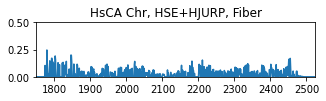

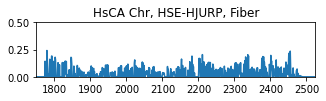

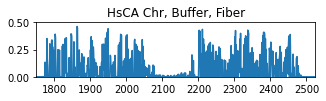

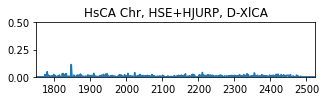

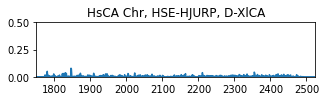

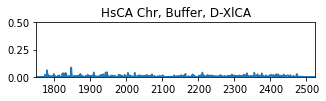

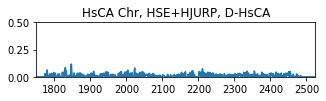

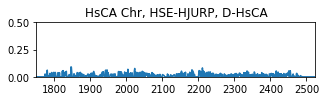

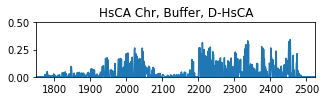

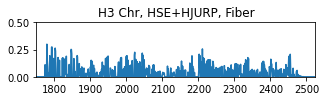

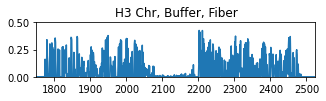

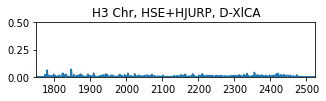

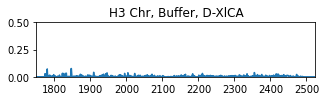

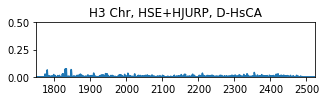

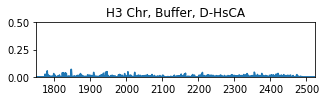

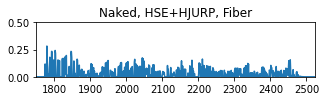

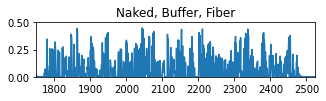

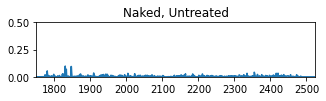

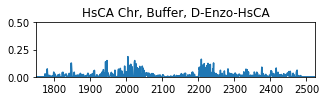

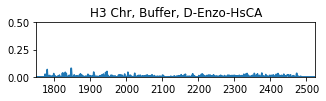

In [57]:
for Bar in Barcode_list:
    plt.figure(figsize=(5,1))
    plt.plot(np.nanmean(AT_prob_arr_bar[Bar]/256>0.90, axis = 0))
    plt.title(Barcode_name[Bar])
    plt.ylim(0,0.5)
    plt.xlim(1750,2525)
    plt.show()

In [23]:
#COVERAGE
def coverage(barcodes_list, coverage_Fwd_bar, coverage_Rev_bar, templatelength = 3022, label_name = Barcode_name):
    coverage_bar = {new_list: [] for new_list in barcodes_list}
    x = np.arange(templatelength)    
    for i in barcodes_list:
        coverage_bar[i] = coverage_Fwd_bar[i] + coverage_Rev_bar[i]
        plt.plot(x, np.array(coverage_bar[i]), label = label_name[i])
    plt.xlabel('bp of 1x601 plasmid', fontsize = 14)
    plt.ylabel('# of read', fontsize = 14)
    plt.title('coverage', fontsize=14)
    legend = plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlim(1770,2490)
    plt.show()
    return coverage_bar

In [24]:
Barcode_list

['21',
 '22',
 '03',
 '04',
 '23',
 '24',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20']

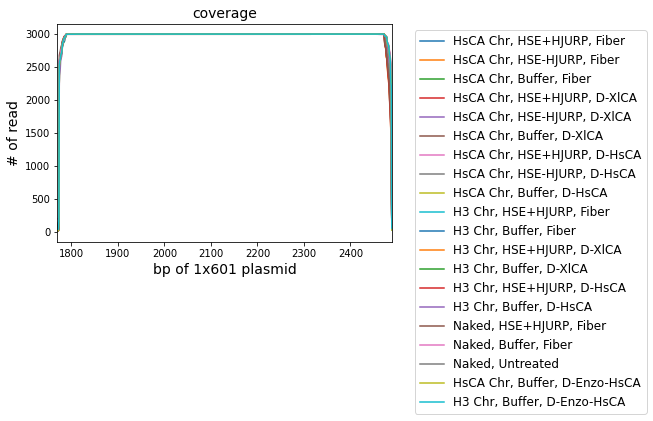

In [58]:
coverage_bar = coverage(Barcode_list, coverage_Fwd_bar, coverage_Rev_bar)

In [26]:
#Calculating FDR from CDF

In [27]:
barcodes_list = Barcode_list

In [28]:
np.shape(AT_prob_arr_bar['21'][:,1750:2500])

(3000, 750)

In [29]:
AT_prob_arr_bar_trim750 = {}
for Bar in Barcode_list:
    AT_prob_arr_bar_trim750[Bar] = AT_prob_arr_bar[Bar][:,1750:2500]

In [30]:
histo = {new_list: [] for new_list in barcodes_list}
bin_edges = {new_list: [] for new_list in barcodes_list}
AT_prob_list_clean_bar = {new_list: [] for new_list in barcodes_list}
cdf = {new_list: [] for new_list in barcodes_list}
for i in barcodes_list:
    AT_prob_list_clean_bar[i] = np.reshape(AT_prob_arr_bar_trim750[i][AT_prob_arr_bar_trim750[i]>=0],-1)
    histo[i], bin_edges[i] = np.histogram(AT_prob_list_clean_bar[i]/255, density = True, bins=1000)
    cdf[i] = np.cumsum(histo[i])/np.nansum(histo[i])
    

In [31]:
#FDR calculation without binning

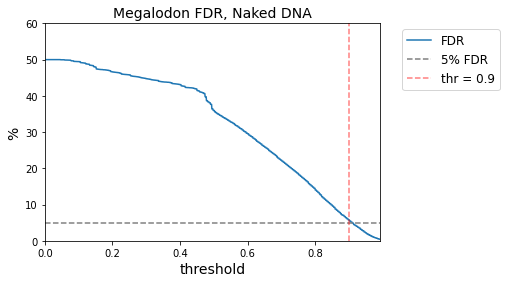

In [38]:
plt.plot(bin_edges['17'][:-1],np.divide((1-cdf['18']),((1-cdf['17'])+(1-cdf['18'])))*100, label = 'FDR' )
plt.ylabel('%', fontsize=14)
plt.xlabel('threshold', fontsize=14)
plt.axhline(5, color='grey', linestyle='--', label = '5% FDR')
plt.axvline(0.9, color='red', alpha=0.5, linestyle='--', label = 'thr = 0.9')
legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Megalodon FDR, Naked DNA', fontsize = 14)
plt.ylim(0,60)
plt.xlim(0,0.99)
#plt.xlabel('threshold', fontsize=14)
#legend =plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [39]:
#making a binary mod prob > thr array using numpy
def binary_mod(barcodes_list, AT_prob_arr_bar, coverage_bar, AT_mod_arr_bar={}, thr=90):
    thr256 = thr/100*256
    try: AT_mod_arr_bar
    except NameError: 
        AT_mod_arr_bar = {new_list: [] for new_list in barcodes_list}
    for i in barcodes_list:
        AT_mod_arr_bar[i] = np.ndarray.astype(AT_prob_arr_bar[i] >= thr256, int)
    return AT_mod_arr_bar

In [40]:
AT_mod_arr_bar = binary_mod(Barcode_list, AT_prob_arr_bar, coverage_bar)

In [41]:
#making a binary mod prob > thr array using numpy
def frac_m6A(barcodes_list, AT_mod_arr_bar, A_n_bar, m6A_over_A_bar = {}):
    N_mod_bar = {new_list: [] for new_list in barcodes_list}
    for i in barcodes_list:
        N_mod_bar[i] = AT_mod_arr_bar[i].sum(axis = 1)
        m6A_over_A_bar[i] = np.ndarray.astype(N_mod_bar[i]/A_n_bar[i], float)
    return m6A_over_A_bar

In [42]:
m6A_over_A_bar = frac_m6A(Barcode_list, AT_mod_arr_bar, A_n_bar)

In [43]:
colorpal = ['#BB4420','#FFBC0A','#053C5E','#A9E5BB','#610345','#2D1E2F','#559CAD','#5E747F', '#FF0000', '#00FF00', '#FFFF00']

In [44]:
def plot_m6A_over_A_combined(barcodes_list, m6A_over_A_bar, ylimit=(0,22), xlimit = (0,1), num_bins = 100, label_name = Barcode_name, colorpal = ['#FFBC0A','#053C5E','#559CAD','#610345','#A9E5BB','#2D1E2F','#BB4420','#5E747F']):

    def export_legend(legend, filename="legend.png"):
        fig  = legend.figure
        fig.canvas.draw()
        bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(filename, dpi=300, bbox_inches=bbox)
        return
    fig, ax1 = plt.subplots(figsize = (3.6,2.4))
    barcodes_list_str = ''
    a = 0
    alp = [0.6,0.6,0.4,0.4]
    for i in barcodes_list:
        barcodes_list_str += '_' + str(i)
        ax1.hist(m6A_over_A_bar[i], bins = 75, density = True, alpha = alp[a], label = label_name[i], color = colorpal[a], histtype = 'barstacked')
        ax1.set_ylabel('frequency', fontsize = 14)
        ax1.set_ylim(0,20)
        ax1.set_xlabel('mA/A per read', fontsize = 14)
        ax = ax1.twinx()
        ax.hist(m6A_over_A_bar[i], bins = 1000, density = True, alpha = 1, label = label_name[i], cumulative=True, histtype='step', rwidth = 1, color = colorpal[a])
        ax.set_ylabel('fraction of reads', fontsize = 14)
        ax.set_ylim(0,1)
        a += 1
        legend = plt.legend(fontsize=12, bbox_to_anchor=(1.2, 1-a/6), loc='upper left')
        
    
    #plt.xlabel('mA/A (per read)', fontsize = 14)
    #plt.legend(fontsize=14)
    #legend = plt.legend(fontsize=12, bbox_to_anchor=(1.2, 1), loc='upper left')
    #plt.ylim(ylimit)
    plt.xlim(xlimit)
    plt.show()
    #if cumul == True:
    fig.savefig(outfolder+'plot_m6A_over_A_Cumulative_hist_combined_90_'+barcodes_list_str, dpi = 300, bbox_inches='tight')
    export_legend(legend, str(outfolder + 'plot_m6A_overA_Cumulative_hist_combined_legend_90_'+ barcodes_list_str + '.png'))
    #else:
    #    fig.savefig(outfolder+'plot_m6A_over_A_'+barcodes_list_str, dpi = 300, bbox_inches='tight')
    #    export_legend(legend, str(outfolder + 'plot_m6A_overA_legend_'+ barcodes_list_str + '.png'))
    

    
    return

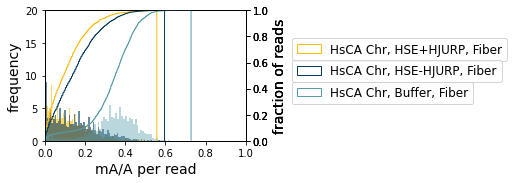

In [45]:
ax = plot_m6A_over_A_combined(['21','22','03'],m6A_over_A_bar, ylimit = [0,1], xlimit = [0,1], num_bins=1000)

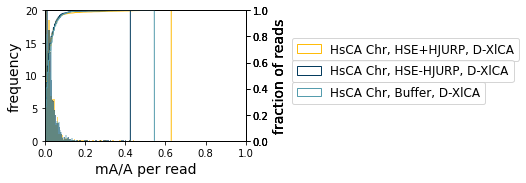

In [46]:
ax = plot_m6A_over_A_combined(['04','23','24'],m6A_over_A_bar, ylimit = [0,1], xlimit = [0,1], num_bins=1000)

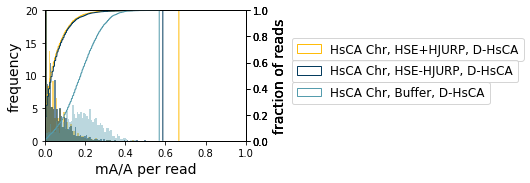

In [47]:
ax = plot_m6A_over_A_combined(['07','08','09'],m6A_over_A_bar, ylimit = [0,1], xlimit = [0,1], num_bins=1000)

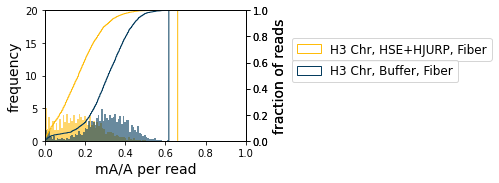

In [48]:
ax = plot_m6A_over_A_combined(['10','11'],m6A_over_A_bar, ylimit = [0,1], xlimit = [0,1], num_bins=1000)

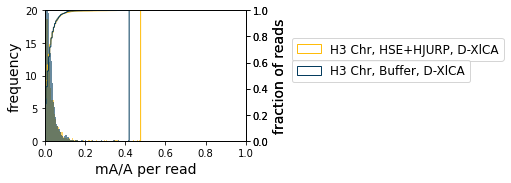

In [49]:
ax = plot_m6A_over_A_combined(['12','13'],m6A_over_A_bar, ylimit = [0,1], xlimit = [0,1], num_bins=1000)

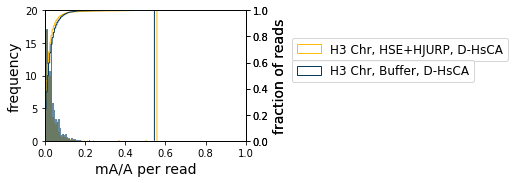

In [50]:
ax = plot_m6A_over_A_combined(['14','15'],m6A_over_A_bar, ylimit = [0,1], xlimit = [0,1], num_bins=1000)

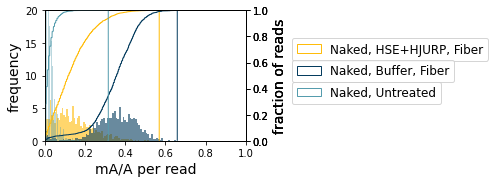

In [51]:
ax = plot_m6A_over_A_combined(['16','17','18'],m6A_over_A_bar, ylimit = [0,1], xlimit = [0,1], num_bins=1000)

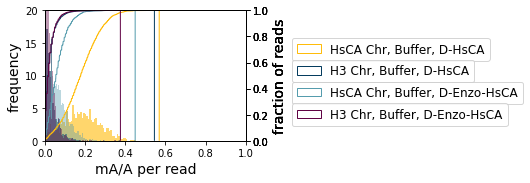

In [59]:
ax = plot_m6A_over_A_combined(['09','15','19','20'],m6A_over_A_bar, ylimit = [0,1], xlimit = [0,1], num_bins=1000)

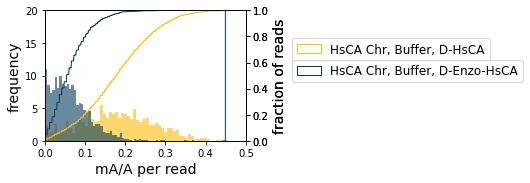

In [60]:
ax = plot_m6A_over_A_combined(['09','19'],m6A_over_A_bar, ylimit = [0,1], xlimit = [0,0.5], num_bins=1000)

### Binning and Sensitivity measurement

In [61]:
AT_prob_arr_bar_filt50 = {}
for i in Barcode_list:
    AT_prob_arr_bar_filt50[i] = AT_prob_arr_bar[i]
    AT_prob_arr_bar_filt50[i][AT_prob_arr_bar[i]<=130] = 0

In [62]:
for bp in ['A','T','AT']:
    AT_prob_arr_bar_filt50[bp] = np.zeros((3000,3022))
    AT_prob_arr_bar_filt50[bp][:] = np.NaN
for baseind in A_pos:
    AT_prob_arr_bar_filt50['A'][:,baseind] = 130
for baseind in T_pos:
    AT_prob_arr_bar_filt50['T'][:,baseind] = 130
for baseind in A_pos:
    AT_prob_arr_bar_filt50['AT'][:,baseind] = 130
for baseind in T_pos:
    AT_prob_arr_bar_filt50['AT'][:,baseind] = 130


#### Set bin and step sizes here:

In [63]:
## Bin each read of 730 bp into 20 bp bins overlapping bins, 10 bp stepsize, Binning to identify at least 1 mA probability
binsize = 50
stepsize = 1
templatelength = 3022

In [64]:
Barcode_name['A'] = 'A density'
Barcode_name['T'] = 'T density'
Barcode_name['AT'] = 'AT density'


In [65]:
colorpal = ['#BB4420','#053C5E','#610345','#2D1E2F','#A9E5BB','#FFBC0A','#559CAD', '#5E747F', '#FF0000','#00FF00', '#FFFF00']

### Average probability for each bin on read, and then average and normalize to Fiberseq and untreated

In [66]:
## Bin each read of 730 bp into 20 bp bins overlapping bins, 10 bp stepsize , Binning by averaging probability
AT_prob_arr_bin_mA = {}
for i in ['21','22', '03', '04', '23','24','07','08','09','10', '11', '12','13','14','15','16','17','18','19','20','A', 'T', 'AT']:
    AT_prob_arr_bin_mA[i] = np.zeros((3000,int(templatelength/stepsize)))
    indx = 0
    for a in range(stepsize,templatelength, stepsize):
        AT_prob_arr_bin_mA[i][:,indx] = np.nan_to_num(np.nanmean(AT_prob_arr_bar_filt50[i][:,a-int(binsize/2):a+int(binsize/2)], axis=1))/256
        indx += 1

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


In [67]:
np.shape(AT_prob_arr_bin_mA['21'])

(3000, 3022)

In [68]:
AT_prob_arr_bin_mA_trim750 = {}
for Bar in Barcode_list:
    AT_prob_arr_bin_mA_trim750[Bar] = AT_prob_arr_bin_mA[Bar][:,1750:2500]

In [69]:
AT_prob_arr_bin_mA_trim450 = {}
for Bar in Barcode_list:
    AT_prob_arr_bin_mA_trim450[Bar] = AT_prob_arr_bin_mA[Bar][:,1900:2350]

In [70]:
np.shape(AT_prob_arr_bin_mA_trim750['21'])

(3000, 750)

In [71]:
np.shape(AT_prob_arr_bin_mA_trim450['21'])

(3000, 450)

### Binned mA/A

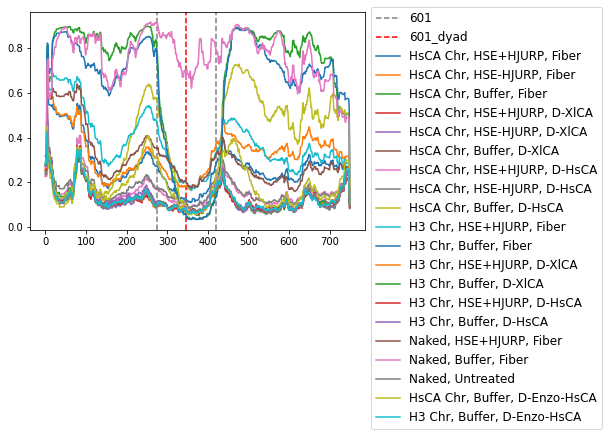

In [72]:
plt.axvline(274,linestyle = '--',color = 'black', alpha = 0.5)
plt.axvline(421,linestyle = '--',color = 'black', alpha = 0.5, label = '601')
plt.axvline(347,linestyle = '--',color = 'r', alpha = 1, label = '601_dyad')
for Bar in Barcode_list:
    plt.plot(np.nanmean(AT_prob_arr_bin_mA_trim750[Bar]>0.6, axis = 0), label = Barcode_name[Bar])
plt.legend(fontsize = 12, bbox_to_anchor=(1,1.05))

plt.show()

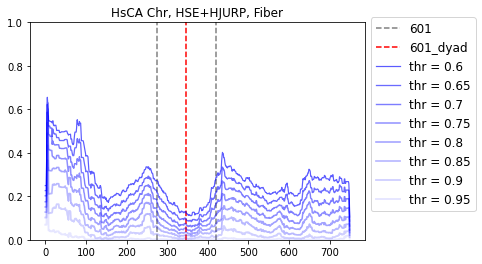

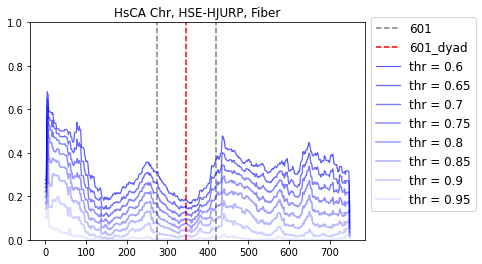

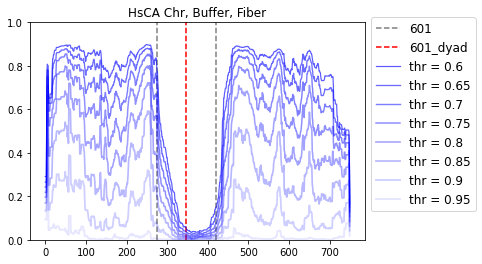

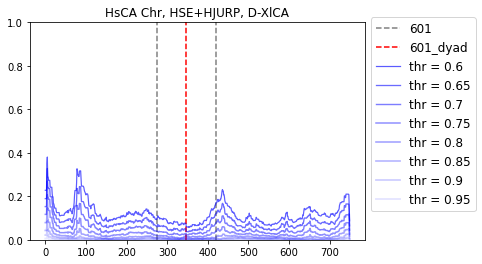

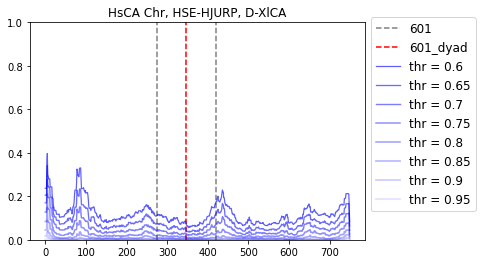

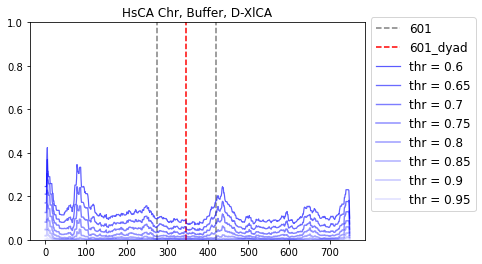

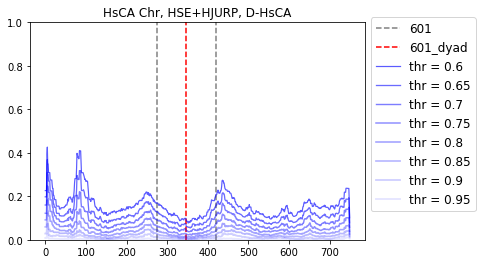

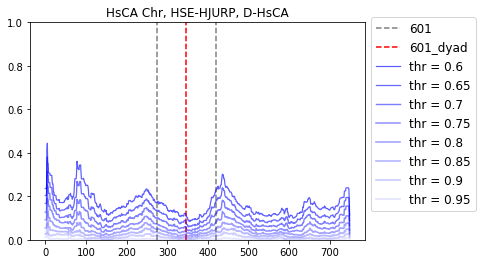

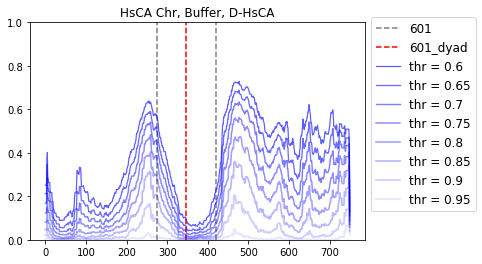

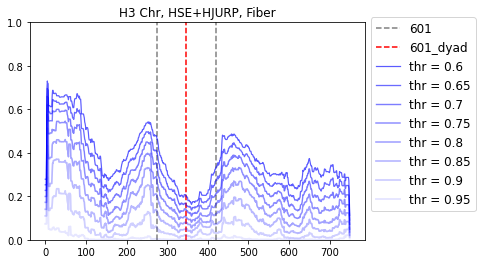

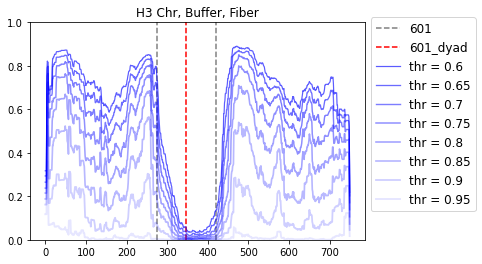

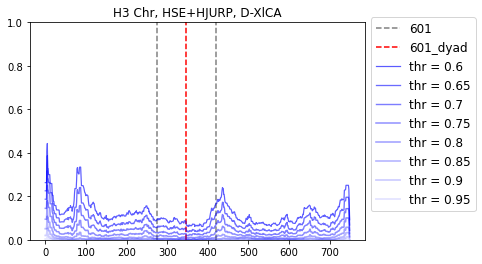

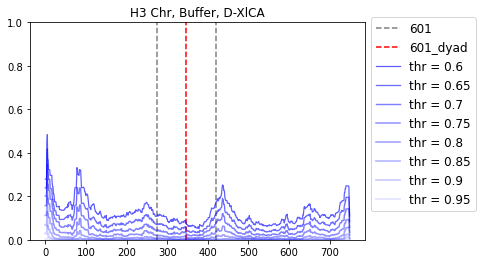

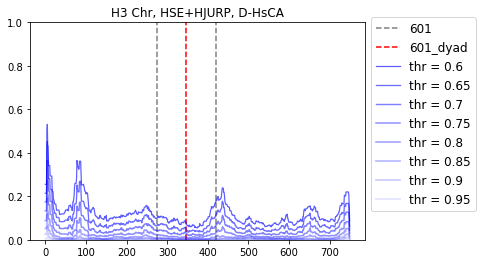

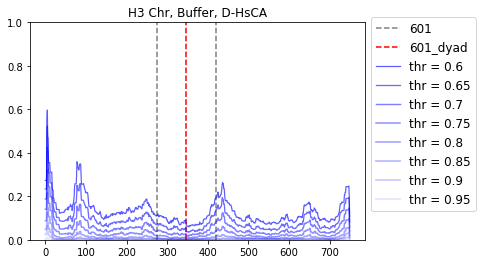

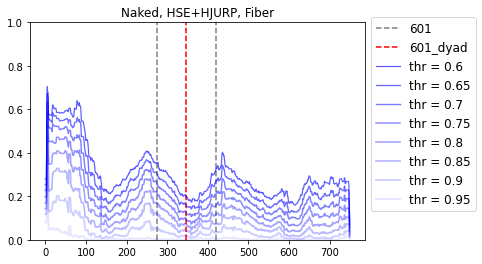

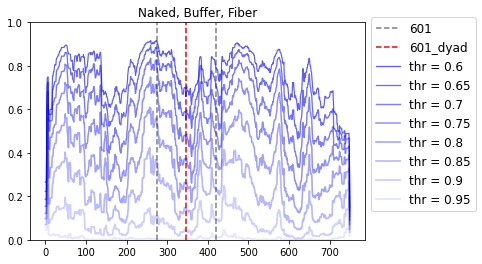

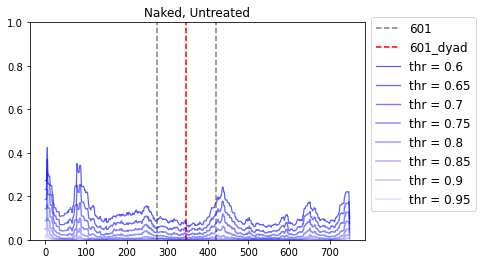

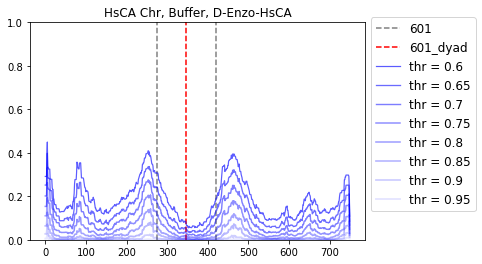

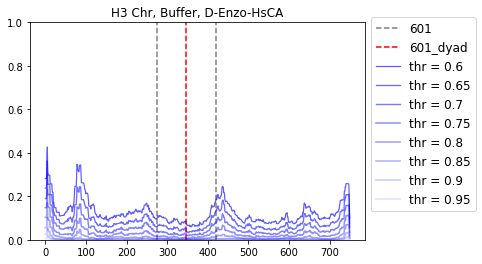

In [85]:
for Bar in Barcode_list:

    plt.axvline(274,linestyle = '--',color = 'black', alpha = 0.5)
    plt.axvline(421,linestyle = '--',color = 'black', alpha = 0.5, label = '601')
    plt.axvline(347,linestyle = '--',color = 'r', alpha = 1, label = '601_dyad')

    for thr in np.arange(0.6,1.0,0.05):
        plt.plot(np.nanmean(AT_prob_arr_bin_mA_trim750[Bar]>thr, axis = 0), label = 'thr = '+str(np.round(thr,2)), color = 'b', alpha = 1 - thr*thr, linewidth = thr*2)
    plt.legend(fontsize = 12, bbox_to_anchor=(1,1.05))
    plt.ylim(0,1)
    plt.title(Barcode_name[Bar])
    plt.show()

In [86]:
seq_601 = 'ACAGGATGTATATATCTGACACGTGCCTGGAGACTAGGGAGTAATCCCCTTGGCGGTTAAAACGCGGGGGACAGCGCGTACGTGCGTTTAAGCGGTGCTAGAGCTGTCTACGACCAATTGAGCGGCCTCGGCACCGGGATTCTCCAG'

In [87]:
array_str.index(seq_601)-1770

274

In [88]:
array_str.index('GCGCGTACG')-1770

347

In [89]:
array_str.index(seq_601)-1770+len(seq_601)

421

In [90]:
#Identifying reads that have at least 20 % bins with average methylation probability > 0.6

### Clustering reads by bins with methylation > thr

In [91]:
m6ABlue = sns.light_palette("#053C5E", 1000)
m6ABlue[0] = (1,1,1)

In [92]:
d_rows={}
row_linkage_mod = {}

In [97]:
for i in Barcode_list:

    d_rows[i]=pairwise_distances(np.asarray(AT_prob_arr_bin_mA_trim750[i]>0.6),metric='jaccard')

    row_linkage_mod[i] = hierarchy.linkage(ssd.squareform(d_rows[i]), method='average',optimal_ordering=True)
    

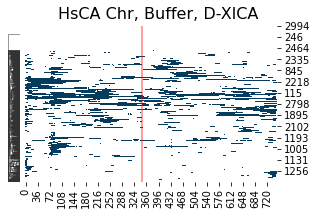

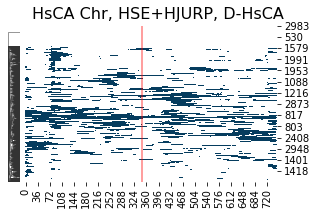

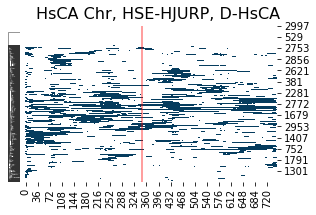

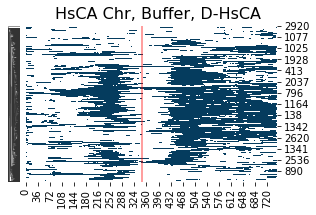

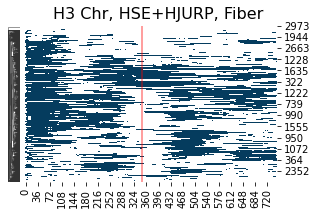

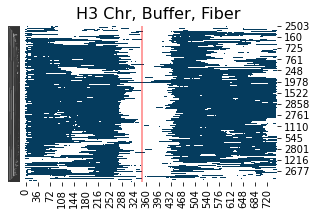

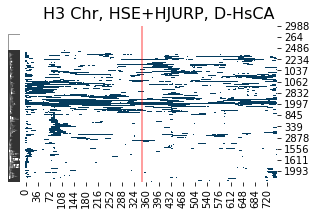

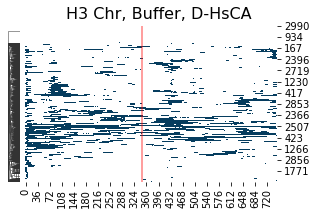

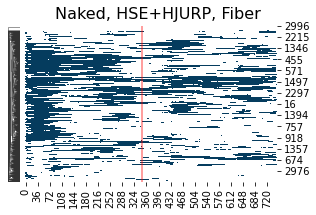

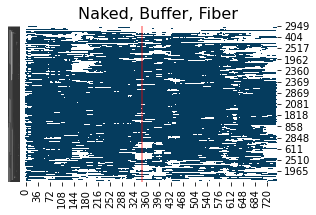

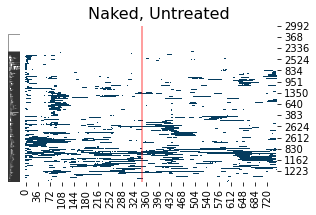

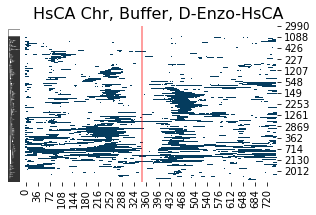

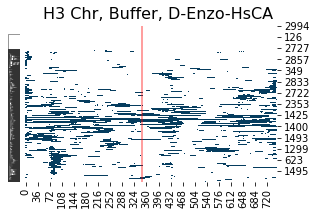

In [102]:
for i in ['24','07','08','09','10','11','14','15','16','17','18','19','20']:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA_trim750[i]>0.6), pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,3), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    plt.axvline(347,0,1, color = 'red', alpha = 0.5)
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    clstmap.savefig(outfolder + 'cluster_mod06_' + str(i) + '.png', dpi=300)
    #clstmap.savefig(outfolder + 'cluster_mod06_' + str(i) + '.pdf', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

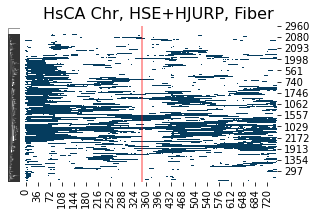

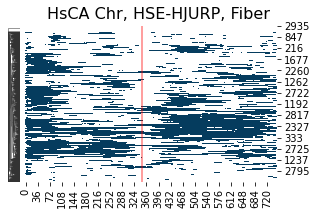

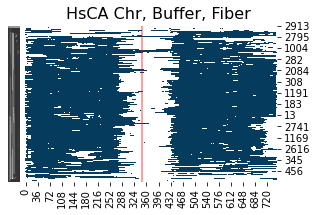

In [98]:
for i in ['21','22','03']:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA_trim750[i]>0.6), pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,3), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    plt.axvline(347,0,1, color = 'red', alpha = 0.5)
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    clstmap.savefig(outfolder + 'cluster_mod06_' + str(i) + '.png', dpi=300)
    #clstmap.savefig(outfolder + 'cluster_mod06_' + str(i) + '.pdf', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

In [95]:
for i in ['04','23','12','13']:

    d_rows[i]=pairwise_distances(np.asarray(AT_prob_arr_bin_mA_trim750[i]>0.6),metric='jaccard')

    row_linkage_mod[i] = hierarchy.linkage(ssd.squareform(d_rows[i]), method='average',optimal_ordering=True)
    

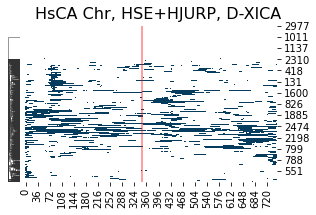

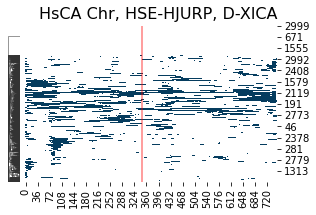

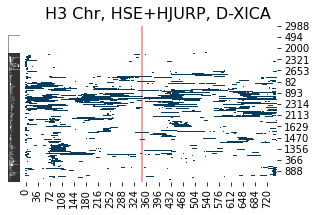

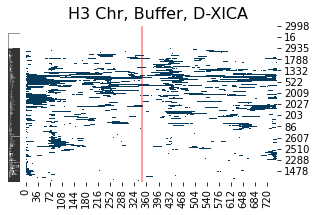

In [96]:
for i in ['04','23','12','13']:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA_trim750[i]>0.6), pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,3), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    plt.axvline(347,0,1, color = 'red', alpha = 0.5)
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    clstmap.savefig(outfolder + 'cluster_mod06_' + str(i) + '.png', dpi=300)
    #clstmap.savefig(outfolder + 'cluster_mod06_' + str(i) + '.pdf', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

In [95]:
for i in ['04','23','12','13']:

    d_rows[i]=pairwise_distances(np.asarray(AT_prob_arr_bin_mA_trim750[i]>0.6),metric='jaccard')

    row_linkage_mod[i] = hierarchy.linkage(ssd.squareform(d_rows[i]), method='average',optimal_ordering=True)
    

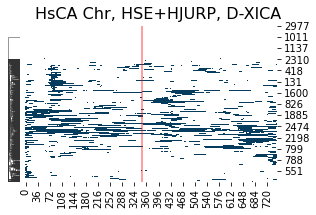

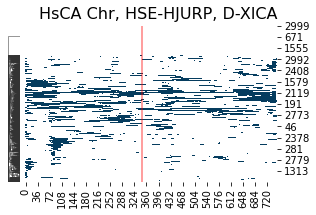

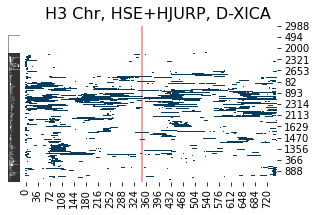

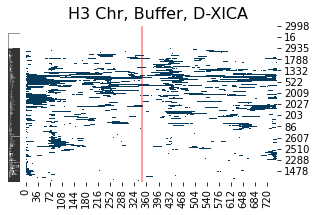

In [96]:
for i in ['04','23','12','13']:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA_trim750[i]>0.6), pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,3), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    plt.axvline(347,0,1, color = 'red', alpha = 0.5)
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    clstmap.savefig(outfolder + 'cluster_mod06_' + str(i) + '.png', dpi=300)
    #clstmap.savefig(outfolder + 'cluster_mod06_' + str(i) + '.pdf', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

### Trim450 instead

In [103]:
d_rows_450 = {}
row_linkage_mod2_450 = {}

In [104]:
for i in Barcode_list:

    d_rows_450[i]=pairwise_distances(np.asarray(AT_prob_arr_bin_mA_trim450[i]>0.6),metric='jaccard')

    row_linkage_mod2_450[i] = hierarchy.linkage(ssd.squareform(d_rows_450[i]), method='average',optimal_ordering=True)

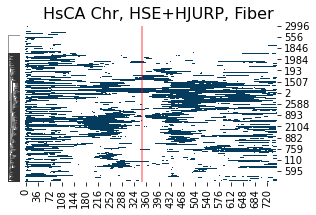

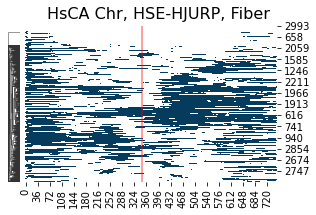

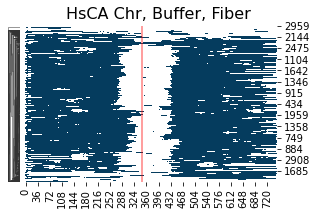

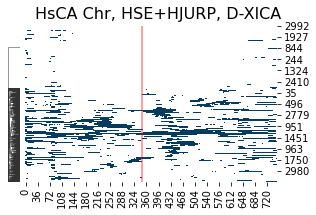

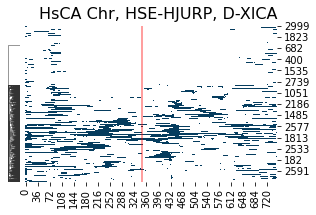

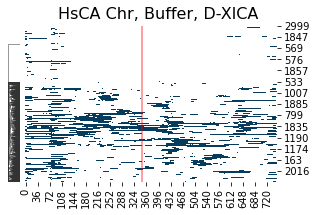

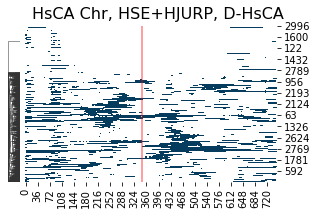

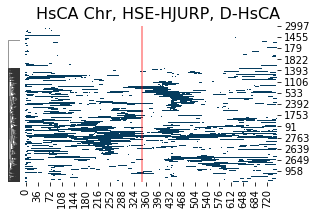

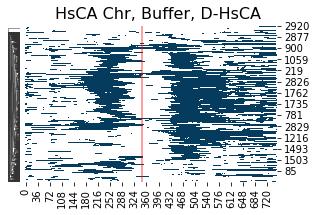

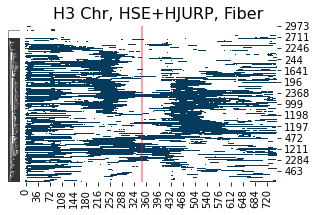

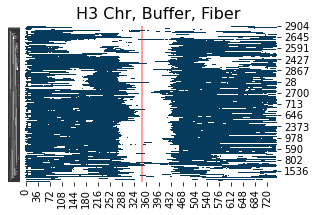

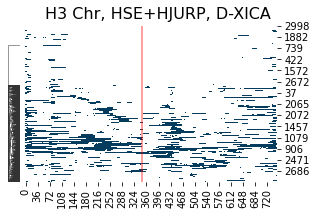

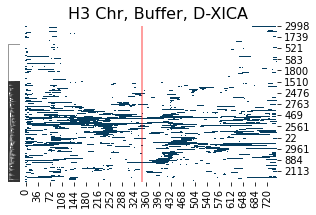

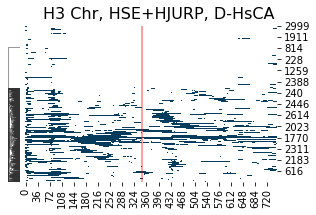

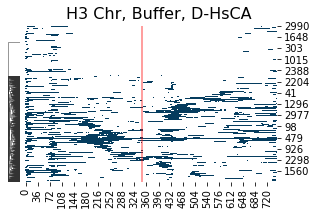

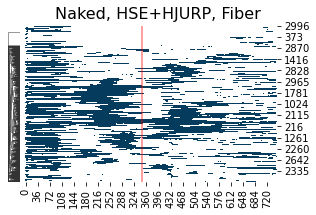

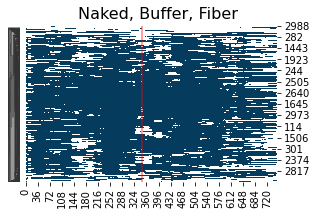

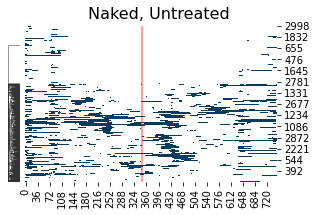

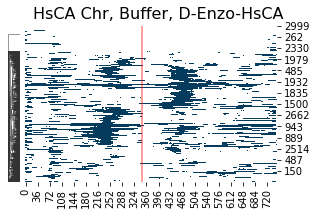

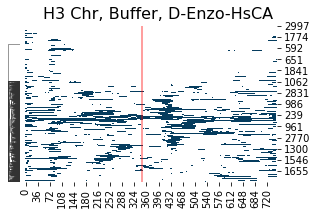

In [105]:
for i in Barcode_list:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA_trim750[i]>0.6), pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,3), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod2_450[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    plt.axvline(347,0,1, color = 'red', alpha = 0.5)
    #plt.axvline(606,0,1, color = 'g', alpha = 0.5)
    #plt.axvline(106,0,1, color = 'g', alpha = 0.5)
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    clstmap.savefig(outfolder + 'clusterby450_mod06_' + str(i) + '.png', dpi=300)
    #clstmap.savefig(outfolder + 'clusterby450_mod06_' + str(i) + '.pdf', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()

### Trim450 and higher threshold

In [119]:
d_rows_450_09 = {}
row_linkage_mod2_450_09 = {}

In [110]:
for i in Barcode_list:

    d_rows_450_09[i]=pairwise_distances(np.asarray(AT_prob_arr_bin_mA_trim450[i]>0.9),metric='jaccard')

    row_linkage_mod2_450_09[i] = hierarchy.linkage(ssd.squareform(d_rows_450_09[i]), method='average',optimal_ordering=True)

KeyError: '06'

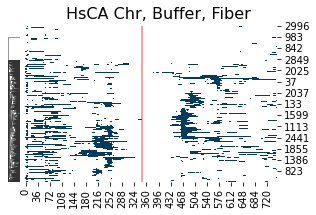

In [118]:
for i in ['03','24','09']:
    
    clstmap=sns.clustermap(np.asarray(AT_prob_arr_bin_mA_trim750[i]>0.9), pivot_kws=None, method='single', metric='jaccard', z_score=None, standard_scale=None, figsize=(4.5,3), cbar_kws=None, cbar_pos=None, row_cluster=True, col_cluster=False, row_linkage=row_linkage_mod2_450_09[i], col_linkage=None, cmap = m6ABlue, dendrogram_ratio=0.05)
    plt.axvline(347,0,1, color = 'red', alpha = 0.5)
    #plt.axvline(606,0,1, color = 'g', alpha = 0.5)
    #plt.axvline(106,0,1, color = 'g', alpha = 0.5)
    clstmap.fig.suptitle(str(Barcode_name[i]), fontsize=16)
    clstmap.savefig(outfolder + 'clusterby450_mod09_' + str(i) + '.png', dpi=300)
    #clstmap.fig.suptitle(str(Barcode_name[i] + ', m6A smoothed prob > '+ str(thr) + ', clustered'), fontsize=16)
    clstmap.fig.show()